In [26]:
import sys
import re
import os
import requests
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [13]:
## save the book locally
if not os.path.exists('sherlock-holmes.txt'):
    text = requests.get('https://www.gutenberg.org/files/1661/1661-0.txt').text
    with open("sherlock-holmes.txt", "w") as text_file:
        text_file.write(text)

In [4]:
## read in the book        
text = open('sherlock-holmes.txt', 'r').read()

In [6]:
text[:100]

"\nProject Gutenberg's The Adventures of Sherlock Holmes, by Arthur Conan Doyle\n\nThis eBook is for the"

In [14]:
## do some basic parsing and cleaning of sentences
stop_pattern = '\.|\?|\!'
sentences = re.split(stop_pattern, text)
sentences = [re.sub("\r|\n"," ",s.lower()) for s in sentences][3:]

In [15]:
sentences[:10]

['net   title: the adventures of sherlock holmes  author: arthur conan doyle  release date: november 29, 2002 [ebook #1661] last updated: may 20, 2019  language: english  character set encoding: utf-8  *** start of this project gutenberg ebook the adventures of sherlock holmes ***    produced by an anonymous project gutenberg volunteer and jose menendez    cover    the adventures of sherlock holmes    by arthur conan doyle    contents      i',
 '     a scandal in bohemia    ii',
 '    the red-headed league    iii',
 '   a case of identity    iv',
 '    the boscombe valley mystery    v',
 '     the five orange pips    vi',
 '    the man with the twisted lip    vii',
 '   the adventure of the blue carbuncle    viii',
 '  the adventure of the speckled band    ix',
 '    the adventure of the engineerâ\x80\x99s thumb    x']

In [16]:
## extract a few features and create a pandas df
has_sherlock =  [True if re.search("sherlock|holmes",s) else False for s in sentences]
has_watson = [True if re.search("john|watson",s) else False for s in sentences]
df = pd.DataFrame({'text':sentences,'has_sherlock':has_sherlock,'has_watson':has_watson})
df['num_words'] = df['text'].apply(lambda x: len(x.split(" ")))

In [18]:
df.head()

,text,has_sherlock,has_watson,num_words
0,net title: the adventures of sherlock holmes...,True,False,91
1,a scandal in bohemia ii,False,False,13
2,the red-headed league iii,False,False,11
3,a case of identity iv,False,False,11
4,the boscombe valley mystery v,False,False,12


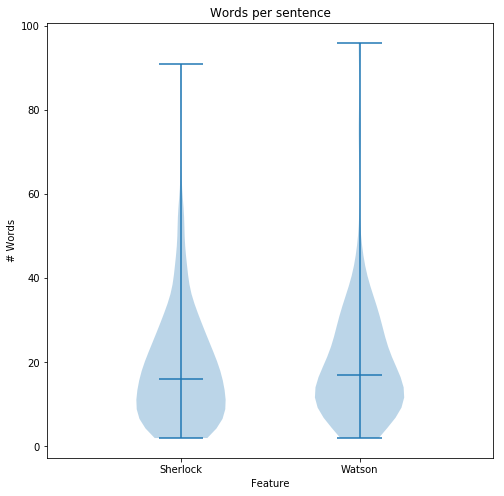

In [19]:
## make eda plot
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

data1 = df[df['has_sherlock']==True]
data2 = df[df['has_watson']==True]

data = [df[df[col]==True]['num_words'].values for col in ['has_sherlock','has_watson']]

pos = [1,2]
ax1.violinplot(data, pos, points=40, widths=0.5,showextrema=True, showmedians=True)

labels = ['Sherlock', 'Watson']
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels)
ax1.set_xlim(0.25, len(labels) + 0.75)
ax1.set_xlabel('Feature')
ax1.set_ylabel('# Words')
ax1.set_title("Words per sentence")

plt.show()

In [24]:
## extract the data to be used in the model from the df
labels = np.zeros(df.shape[0])
labels[(df['has_sherlock'] == True)] = 1
labels[(df['has_watson'] == True)] = 2
df['labels'] = labels
df = df[df['labels']!=0]
X = df['text'].values
y = df['labels'].values

In [27]:
## carry out the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None))
    ])

In [28]:
## train a model
text_clf.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [29]:
## evaluate the model performance
predicted = text_clf.predict(X_test)
print(np.mean(predicted == y_test))

print(metrics.classification_report(y_test, predicted,
      target_names=['sherlock','watson']))

1.0
              precision    recall  f1-score   support

    sherlock       1.00      1.00      1.00       155
      watson       1.00      1.00      1.00        31

   micro avg       1.00      1.00      1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186

